NOTE: It will take around 20 minutes to complete running the entire notebook.

In [83]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# remove warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
np.random.seed(500)

In [85]:
# Load the data
Corpus = pd.read_csv('data/data.csv')
# Uncomment the line below to use the data from the repository
#Corpus = pd.read_csv('https://raw.githubusercontent.com/cdungca/document-classifier/refs/heads/main/data/data.csv')

In [86]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  194 non-null    object
 1   fulltext  189 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [87]:
Corpus.head()

,category,fulltext
0,accountability,United Nations A/60/846/Add.6 Gener...
1,accountability,United Nations A/71/729 General Asse...
2,accountability,United Nations A/72/492 General Asse...
3,accountability,United Nations A/72/492/Add.2 Genera...
4,accountability,United Nations A/73/688 General Asse...


In [88]:
Corpus["category"].value_counts()

category
travel                  75
human resources         66
accountability          42
health and wellbeing    11
Name: count, dtype: int64

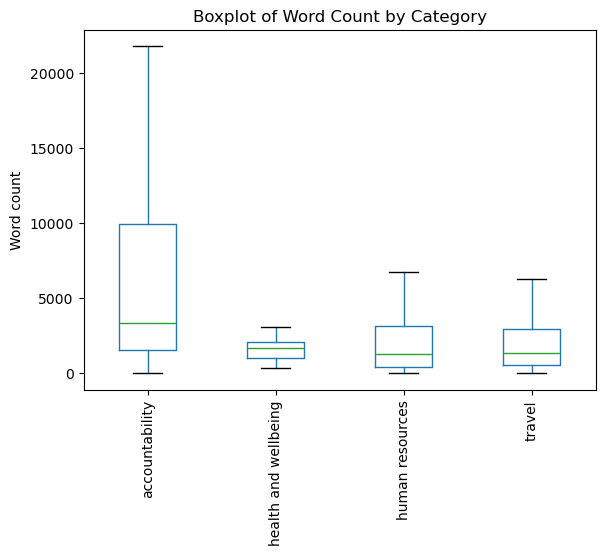

In [89]:
# How long are the texts in the dataset?
Corpus["wordcount"] = Corpus["fulltext"].apply(lambda x: len(str(x).split(" ")))
# plot wordcount per category
Corpus.boxplot("wordcount", by="category", grid=False, showfliers=False)
plt.title("Boxplot of Word Count by Category")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Word count")
plt.xticks(rotation=90)
plt.show()

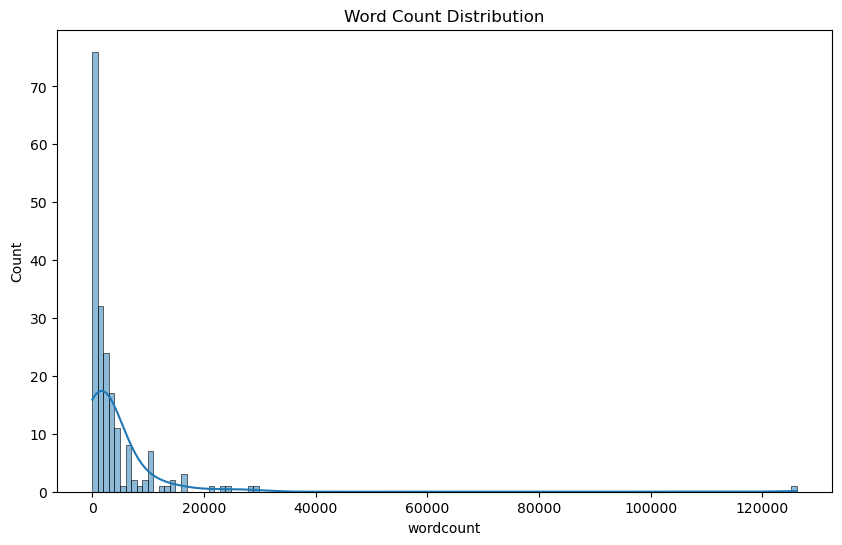

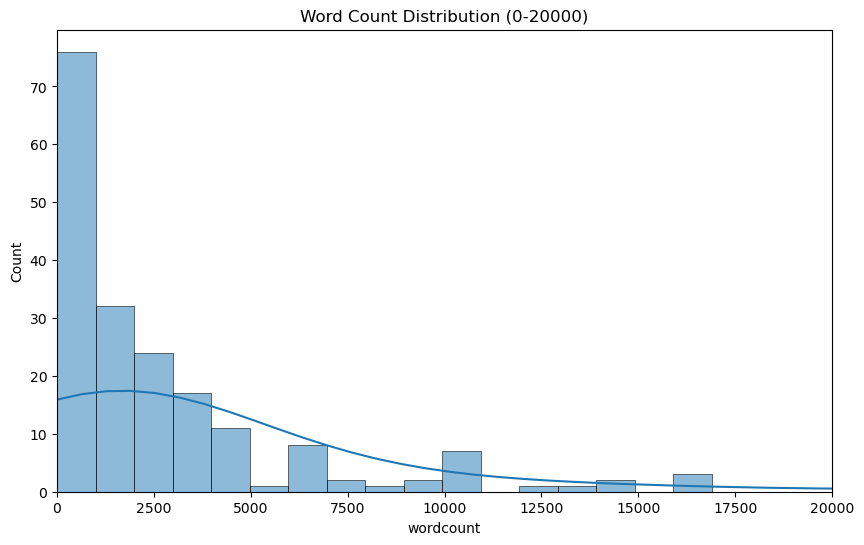

In [90]:
# plot distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.title("Word Count Distribution")
plt.show()
# zoom in on the distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.xlim(0, 20000)
plt.title("Word Count Distribution (0-20000)")
plt.show()


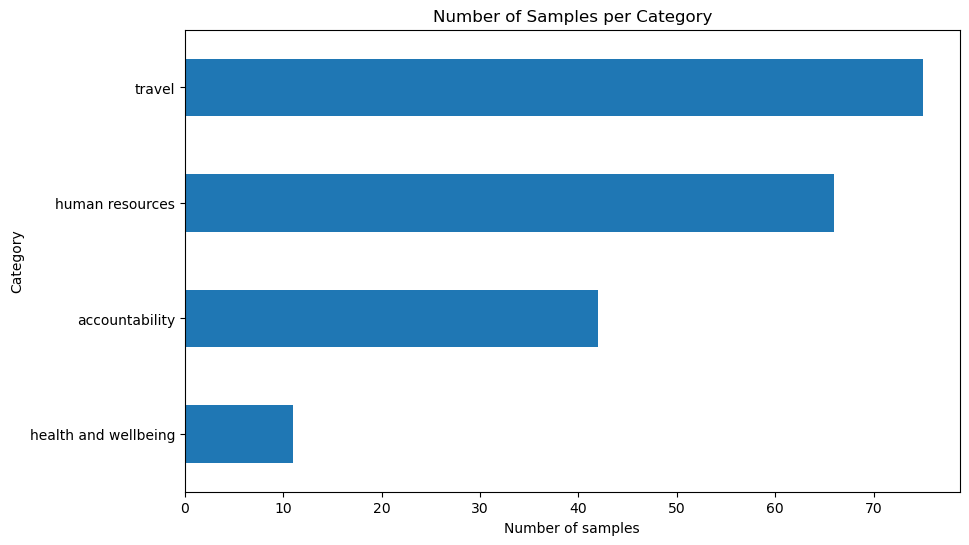

In [91]:
# show category distribution bar horizontal
Corpus["category"].value_counts(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of samples')
plt.ylabel('Category')
plt.title('Number of Samples per Category')
plt.show()


As we can see from the category distribution, we have an imbalance data set. We will use ROC AUC for the metric instead of accuracy.

### Data Pre-processing

1. Remove rows with blank values
2. Change all to lower case
3. Tokenization
4. Remove stop words
5. Remove non-alpha text



In [92]:
Corpus.isnull().sum()

category     0
fulltext     5
wordcount    0
dtype: int64

In [93]:
Corpus.dropna(inplace=True)

In [94]:
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [95]:
def stemmer(text):
    tokenizer = RegexpTokenizer(r'\w{3,}[a-zA=Z]')
    return ' '.join([w for w in tokenizer.tokenize(text)])

In [96]:
Corpus['fulltext'] = Corpus['fulltext'].apply(stemmer)

In [97]:
Corpus.head()

,category,fulltext,wordcount
0,accountability,United Nations General Assembly Distr General ...,8881
1,accountability,United Nations General Assembly Distr General ...,10917
2,accountability,United Nations General Assembly Distr General ...,16716
3,accountability,United Nations General Assembly Distr General ...,126181
4,accountability,United Nations General Assembly Distr General ...,14427


In [98]:
# Check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [99]:
# show record in Corpus with nan values
Corpus[Corpus.isnull().any(axis=1)]

,category,fulltext,wordcount


In [100]:
# Remove rows with empty fields
Corpus = Corpus.dropna()

In [101]:
# Re-check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [102]:
Corpus["category"].value_counts()

category
travel                  74
human resources         64
accountability          40
health and wellbeing    11
Name: count, dtype: int64

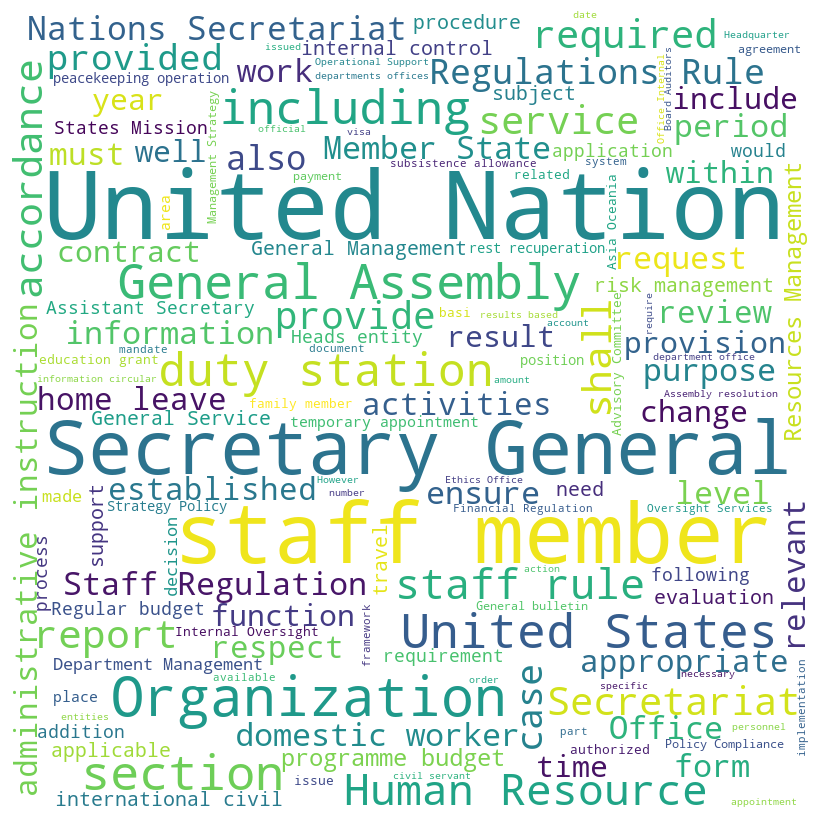

In [103]:
# use wordcloud to visualize the most common words in the dataset
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(' '.join(Corpus['fulltext']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Prepare Train and Test Data

In [104]:
# Prepare test data
X_train, X_test, y_train, y_test = train_test_split(Corpus['fulltext'], Corpus['category'], test_size=0.3, stratify=Corpus['category'].values)

In [105]:
# show value counts for training set
y_train.value_counts()

category
travel                  51
human resources         45
accountability          28
health and wellbeing     8
Name: count, dtype: int64

In [106]:
# show value counts for test set
y_test.value_counts()

category
travel                  23
human resources         19
accountability          12
health and wellbeing     3
Name: count, dtype: int64

### Encode category

In [107]:
Encoder = LabelEncoder()
y_train_encoded = Encoder.fit_transform(y_train)
y_test_encoded = Encoder.fit_transform(y_test)

In [108]:
# Check if all classes are represented in the training set
np.unique(y_train_encoded)

array([0, 1, 2, 3])

In [109]:
# Check if all classes are represented in the test set
np.unique(y_test_encoded)

array([0, 1, 2, 3])

In [110]:
# Define labels and target names
labels = [0, 1, 2, 3]
target_names = ['accountability', 'health and wellbeing', 'human resources', 'travel']

In [111]:
# Define Pipelines using CountVectorizer

# Baseline
cvect_base_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
cvect_log_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                               ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
cvect_nb_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                              ('nb', MultinomialNB())])

# SVM
cvect_svm_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                               ('svm', SVC(probability=True))])

# XGBoost
cvect_xgb_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                               ('xgb', xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='auc'))])

In [112]:
# Define Pipelines using TfidfVectorizer

# Baseline
tvect_base_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english',max_features=1000)),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
tvect_log_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english',max_features=1000)),
                               ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
tvect_nb_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english',max_features=1000)),
                              ('nb', MultinomialNB())])

# SVM
tvect_svm_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english',max_features=1000)),
                               ('svm', SVC(probability=True))])

# XGBoost
tvect_xgb_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english',max_features=1000)),
                               ('xgb', xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='auc'))])

In [113]:
# Define parameters for GridSearchCV

# Logistic Regression
log_param = {'vect__max_df': [0.4, 0.6, 0.8, 1.0],
             'vect__min_df': [0.4, 0.6, 0.8, 1.0],
             'vect__max_features': [100, 500, 1000],
             'log__C': [0.1, 1, 10, 100]}

# Naive Bayes
nb_param = {'vect__max_df': [0.4, 0.6, 0.8, 1.0],
            'vect__min_df': [0.4, 0.6, 0.8, 1.0],
            'vect__max_features': [100, 500, 1000],
            'nb__alpha': [0.1, 1, 10, 100]}

# SVM
svm_param = {'vect__max_df': [0.4, 0.6, 0.8, 1.0],
             'vect__min_df': [0.4, 0.6, 0.8, 1.0],
             'vect__max_features': [100, 500, 1000],
             'svm__C': [0.1, 1, 10, 100]}

# XGBoost
xgb_param = {'vect__max_df': [0.4, 0.6, 0.8, 1.0],
             'vect__min_df': [0.4, 0.6, 0.8, 1.0],
             'vect__max_features': [100, 500, 1000],
             'xgb__max_depth': [2, 4, 6, 10]}

In [114]:
# Function to confusion matrix
def show_conf_matrix(y_test, y_pred, labels, title):
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

In [115]:
# Function for ROC curve
def show_roc_curve(pipeline, X_test, y_test, y_train, labels, title):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_score = pipeline.predict_proba(X_test)

    display = RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        y_score.ravel(),
        name="micro-average OvR",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )

In [116]:
# Function to train and evaluate models
def train_eval_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels, modelname):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    print(pipeline.named_steps)
    print('\n')
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))
    print('\n')
    print('Train AUC Sore: ', "%.2f" % roc_auc_score(y_train, pipeline.predict_proba(X_train), multi_class='ovr', average='micro'))
    print('Test AUC Score: ', "%.2f" % roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr', average='micro'))
    print('\n')
    show_conf_matrix(y_test, y_pred, target_names, modelname)
    print('\n')
    show_roc_curve(pipeline, X_test, y_test, y_train, target_names, modelname)
    return y_pred
    

In [117]:
# Function to train and tune models
def train_tune_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels, param_grid, modelname):
    grid = GridSearchCV(pipeline, param_grid)
    grid.fit(X_train, y_train)
    y_train_pred = grid.predict(X_train)
    y_pred = grid.predict(X_test)
    print(pipeline.named_steps)
    print('\n')
    print(grid.best_params_)
    print('\n')
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))
    print('\n')
    print('Train AUC Sore: ', "%.2f" % roc_auc_score(y_train, grid.predict_proba(X_train), multi_class='ovr', average='micro'))
    print('Test AUC Score: ', "%.2f" % roc_auc_score(y_test, grid.predict_proba(X_test), multi_class='ovr', average='micro'))
    print('\n')
    show_conf_matrix(y_test, y_pred, target_names, modelname)
    print('\n')
    show_roc_curve(grid, X_test, y_test, y_train, target_names, modelname)
    return y_pred

### Evaluate models using CountVectorizer for feature extraction

#### Default parameters

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'dclass': DummyClassifier(strategy='stratified')}


                      precision    recall  f1-score   support

      accountability       0.12      0.08      0.10        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.22      0.21      0.22        19
              travel       0.48      0.52      0.50        23

            accuracy                           0.30        57
           macro avg       0.21      0.20      0.20        57
        weighted avg       0.29      0.30      0.29        57



Train AUC Sore:  0.54
Test AUC Score:  0.56




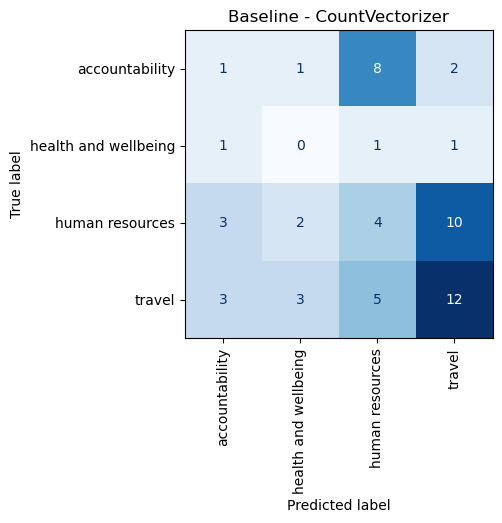

array([2, 0, 0, 2, 0, 2, 2, 3, 3, 1, 2, 2, 2, 3, 3, 1, 3, 0, 2, 2, 3, 1,
       3, 3, 3, 0, 3, 3, 0, 3, 2, 2, 1, 0, 3, 2, 2, 3, 2, 0, 3, 3, 2, 3,
       3, 3, 1, 3, 2, 3, 2, 3, 3, 1, 3, 2, 3])

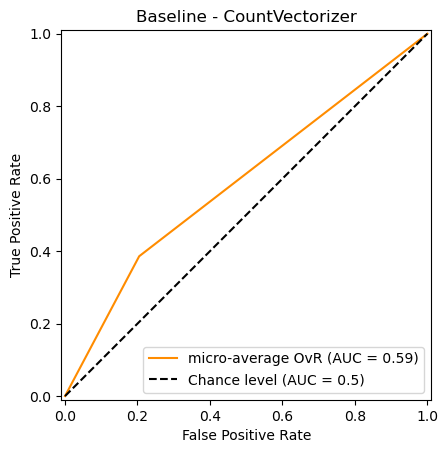

In [118]:
# Baseline
train_eval_model(cvect_base_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Baseline - CountVectorizer')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'log': LogisticRegression(max_iter=10000)}


                      precision    recall  f1-score   support

      accountability       0.82      0.75      0.78        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.57      0.63      0.60        19
              travel       0.75      0.78      0.77        23

            accuracy                           0.68        57
           macro avg       0.53      0.54      0.54        57
        weighted avg       0.67      0.68      0.67        57



Train AUC Sore:  1.00
Test AUC Score:  0.88




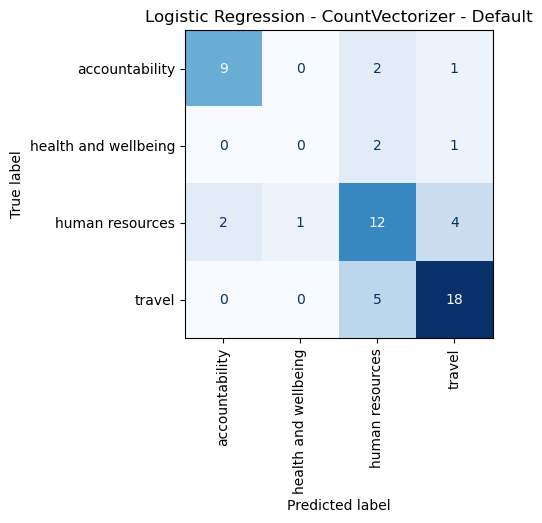

array([0, 2, 2, 0, 2, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 2, 3, 0, 3, 0, 0, 3])

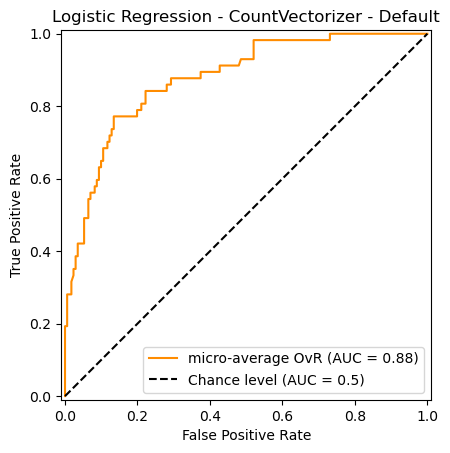

In [119]:
# Logistic Regression
train_eval_model(cvect_log_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Logistic Regression - CountVectorizer - Default')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'nb': MultinomialNB()}


                      precision    recall  f1-score   support

      accountability       0.82      0.75      0.78        12
health and wellbeing       1.00      1.00      1.00         3
     human resources       0.62      0.53      0.57        19
              travel       0.74      0.87      0.80        23

            accuracy                           0.74        57
           macro avg       0.80      0.79      0.79        57
        weighted avg       0.73      0.74      0.73        57



Train AUC Sore:  0.97
Test AUC Score:  0.89




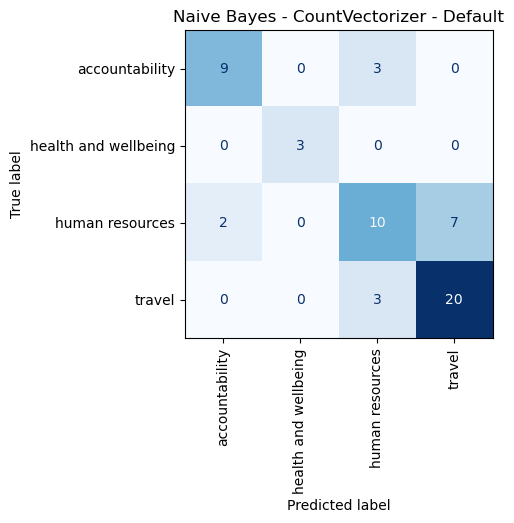

array([0, 2, 3, 0, 0, 2, 0, 3, 2, 3, 0, 1, 2, 0, 3, 0, 3, 2, 3, 2, 3, 2,
       1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 0, 0, 3])

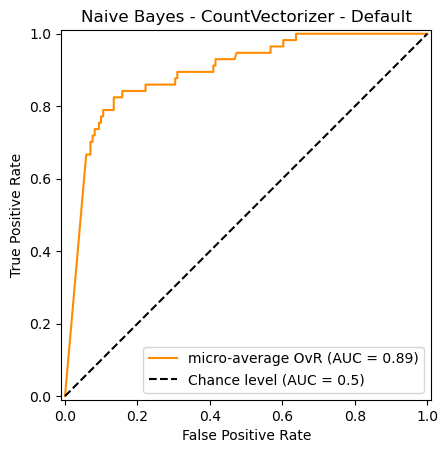

In [120]:
# Naive Bayes
train_eval_model(cvect_nb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Naive Bayes - CountVectorizer - Default')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'svm': SVC(probability=True)}


                      precision    recall  f1-score   support

      accountability       0.86      0.50      0.63        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.67      0.11      0.18        19
              travel       0.47      0.96      0.63        23

            accuracy                           0.53        57
           macro avg       0.50      0.39      0.36        57
        weighted avg       0.59      0.53      0.45        57



Train AUC Sore:  0.94
Test AUC Score:  0.84




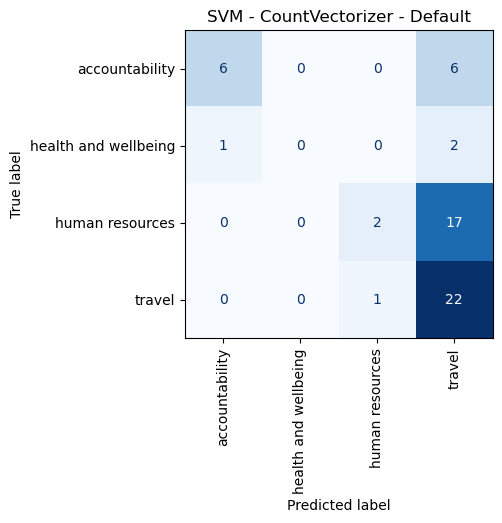

array([0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 2, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 0, 3])

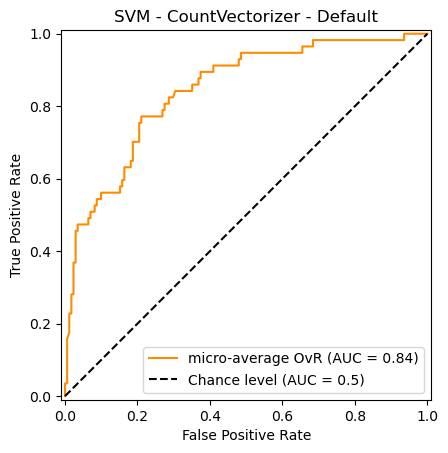

In [121]:
# SVM
train_eval_model(cvect_svm_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'SVM - CountVectorizer - Default')


{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)}


                      precision    recall  f1-score   support

      accountability       0.71      0.83      0.77        12
health and wellbeing       1.00      1.00    

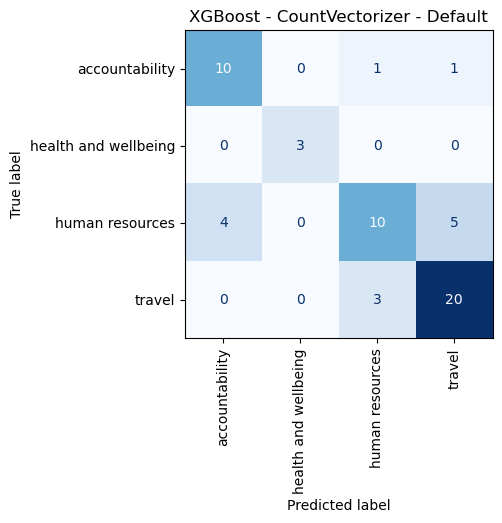

array([0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 0, 1, 2, 0, 3, 0, 3, 3, 2, 2, 3, 2,
       1, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2,
       3, 3, 3, 0, 2, 3, 3, 3, 0, 3, 0, 0, 3], dtype=int64)

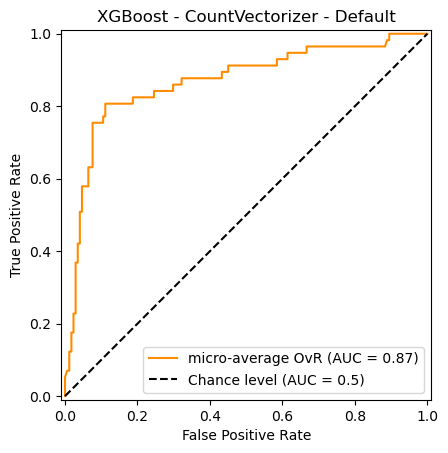

In [122]:
# XGBoost
train_eval_model(cvect_xgb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'XGBoost - CountVectorizer - Default')

#### Tune hyperparameters

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'log': LogisticRegression(max_iter=10000)}


{'log__C': 10, 'vect__max_df': 1.0, 'vect__max_features': 500, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.67      0.67      0.67        12
health and wellbeing       0.67      0.67      0.67         3
     human resources       0.53      0.53      0.53        19
              travel       0.74      0.74      0.74        23

            accuracy                           0.65        57
           macro avg       0.65      0.65      0.65        57
        weighted avg       0.65      0.65      0.65        57



Train AUC Sore:  1.00
Test AUC Score:  0.84




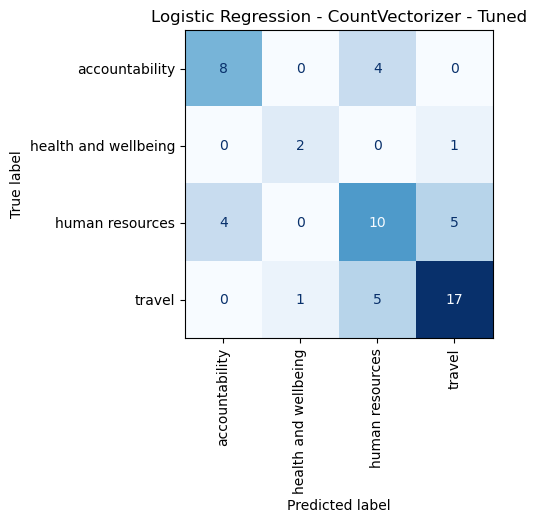

array([0, 2, 2, 0, 2, 2, 0, 3, 0, 3, 0, 1, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       1, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 2, 1, 3, 3, 3, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 2, 3, 0, 3, 0, 0, 3])

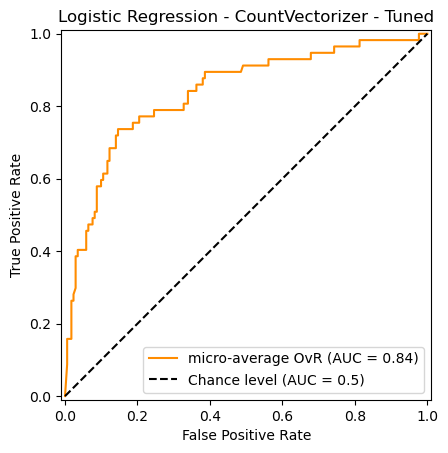

In [123]:
# Logistic Regression
train_tune_model(cvect_log_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, log_param, 'Logistic Regression - CountVectorizer - Tuned')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'nb': MultinomialNB()}


{'nb__alpha': 0.1, 'vect__max_df': 0.6, 'vect__max_features': 100, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.89      0.67      0.76        12
health and wellbeing       1.00      0.33      0.50         3
     human resources       0.67      0.74      0.70        19
              travel       0.73      0.83      0.78        23

            accuracy                           0.74        57
           macro avg       0.82      0.64      0.68        57
        weighted avg       0.76      0.74      0.73        57



Train AUC Sore:  0.96
Test AUC Score:  0.89




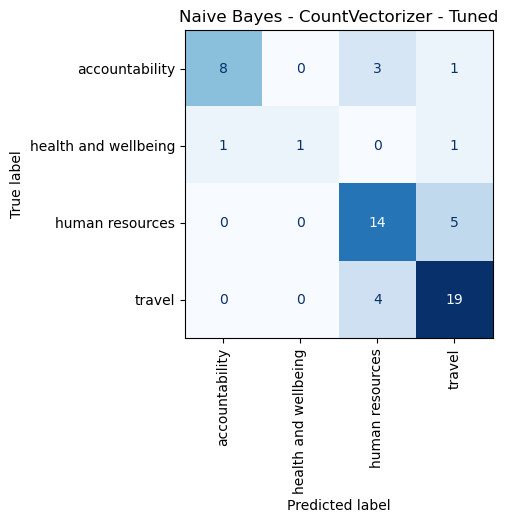

array([0, 2, 3, 0, 2, 2, 0, 3, 2, 3, 0, 0, 2, 0, 3, 2, 3, 2, 2, 2, 3, 2,
       1, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 3, 3, 2, 3, 2, 0, 3])

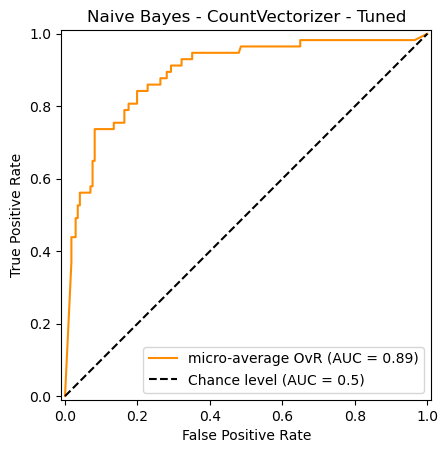

In [124]:
# Naive Bayes
train_tune_model(cvect_nb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, nb_param, 'Naive Bayes - CountVectorizer - Tuned')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'svm': SVC(probability=True)}


{'svm__C': 10, 'vect__max_df': 0.6, 'vect__max_features': 100, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.67      0.33      0.44        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.46      0.58      0.51        19
              travel       0.67      0.78      0.72        23

            accuracy                           0.58        57
           macro avg       0.45      0.42      0.42        57
        weighted avg       0.56      0.58      0.55        57



Train AUC Sore:  0.95
Test AUC Score:  0.85




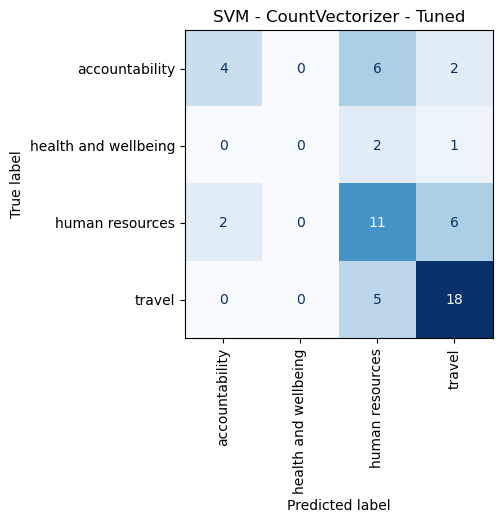

array([0, 2, 2, 0, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 3, 2, 3, 3, 0, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 0, 0, 3])

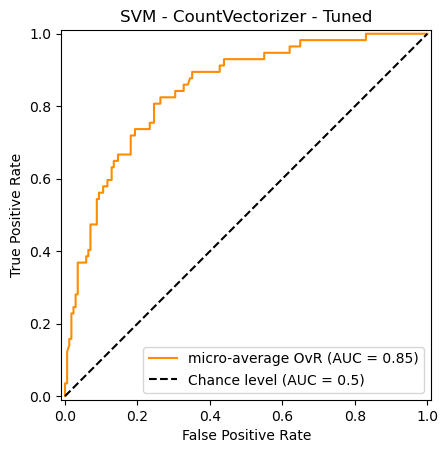

In [125]:
# SVM
train_tune_model(cvect_svm_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, svm_param, 'SVM - CountVectorizer - Tuned')

{'vect': CountVectorizer(max_features=1000, stop_words='english'), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)}


{'vect__max_df': 0.6, 'vect__max_features': 100, 'vect__min_df': 0.4, 'xgb__max_depth': 6}


                      precision    recall  f1-score   support

      accounta

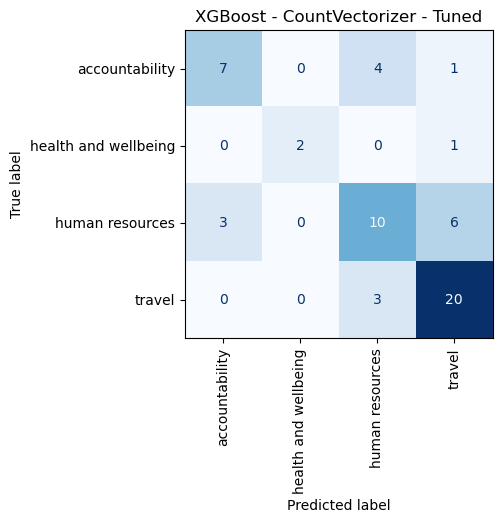

array([0, 3, 2, 0, 2, 2, 2, 3, 0, 3, 0, 1, 2, 0, 3, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 2, 0, 3], dtype=int64)

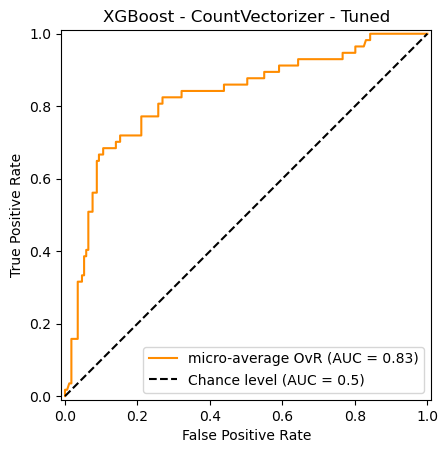

In [126]:
# XGBoost
train_tune_model(cvect_xgb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, xgb_param, 'XGBoost - CountVectorizer - Tuned')

### Evaluate models using TfidfVectorizer feature extraction

#### Default parameters

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'dclass': DummyClassifier(strategy='stratified')}


                      precision    recall  f1-score   support

      accountability       0.23      0.25      0.24        12
health and wellbeing       0.20      0.33      0.25         3
     human resources       0.43      0.47      0.45        19
              travel       0.50      0.39      0.44        23

            accuracy                           0.39        57
           macro avg       0.34      0.36      0.34        57
        weighted avg       0.40      0.39      0.39        57



Train AUC Sore:  0.51
Test AUC Score:  0.52




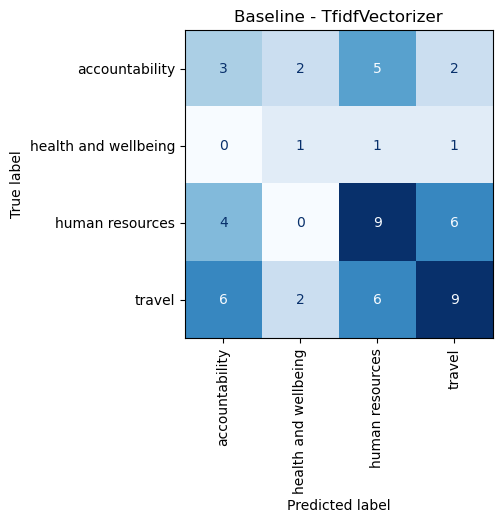

array([2, 3, 0, 2, 2, 2, 0, 2, 2, 3, 1, 2, 0, 0, 3, 3, 2, 0, 3, 2, 0, 0,
       3, 3, 2, 3, 0, 0, 3, 0, 2, 2, 0, 3, 3, 3, 3, 3, 2, 1, 3, 2, 2, 1,
       3, 2, 0, 0, 3, 2, 2, 1, 2, 3, 2, 1, 2])

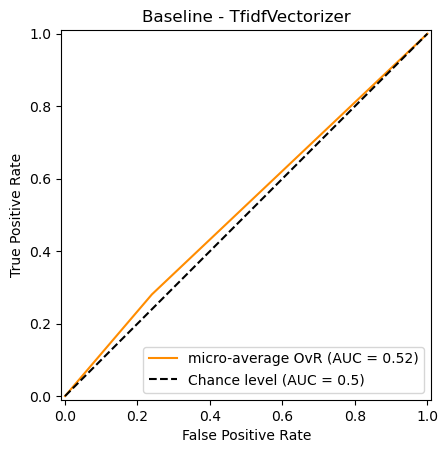

In [127]:
# Baseline
train_eval_model(tvect_base_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Baseline - TfidfVectorizer')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'log': LogisticRegression(max_iter=10000)}


                      precision    recall  f1-score   support

      accountability       0.90      0.75      0.82        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.62      0.68      0.65        19
              travel       0.77      0.87      0.82        23

            accuracy                           0.74        57
           macro avg       0.57      0.58      0.57        57
        weighted avg       0.71      0.74      0.72        57



Train AUC Sore:  0.99
Test AUC Score:  0.90




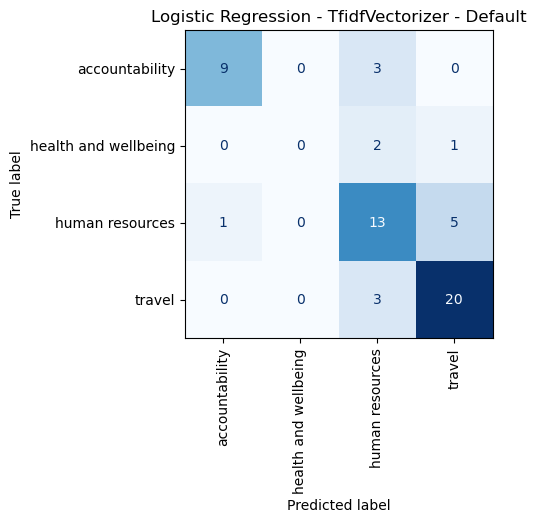

array([0, 2, 3, 0, 0, 2, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
       3, 3, 3, 0, 2, 3, 2, 3, 2, 3, 2, 0, 3])

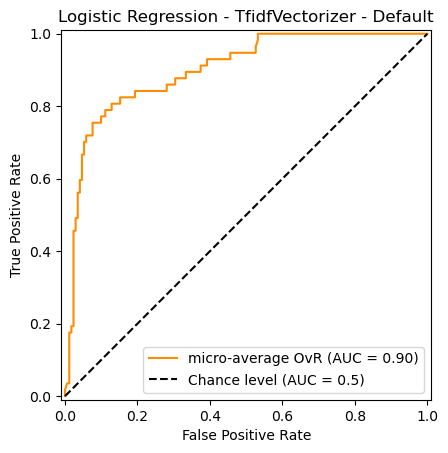

In [128]:
# Logistic Regression
train_eval_model(tvect_log_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Logistic Regression - TfidfVectorizer - Default')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'nb': MultinomialNB()}


                      precision    recall  f1-score   support

      accountability       0.90      0.75      0.82        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.71      0.53      0.61        19
              travel       0.67      0.96      0.79        23

            accuracy                           0.72        57
           macro avg       0.57      0.56      0.55        57
        weighted avg       0.70      0.72      0.69        57



Train AUC Sore:  0.97
Test AUC Score:  0.90




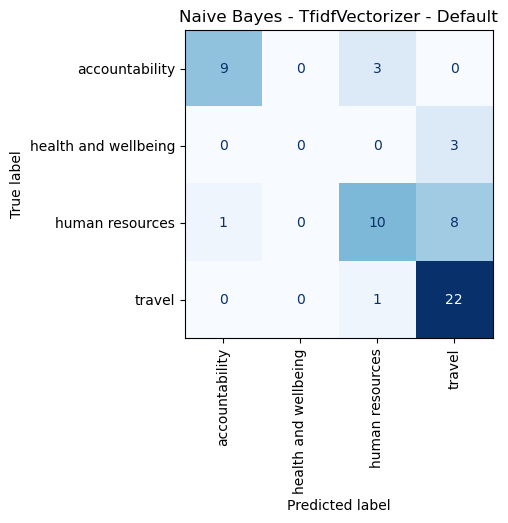

array([0, 2, 3, 0, 0, 2, 0, 3, 2, 3, 0, 3, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 3])

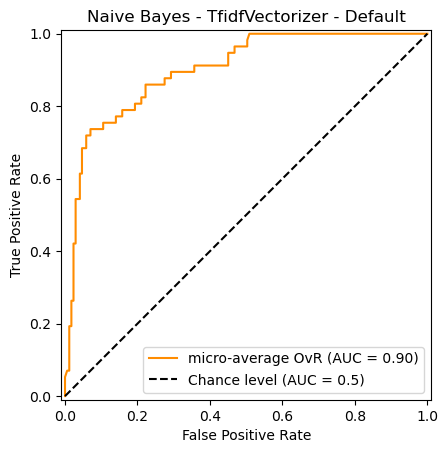

In [129]:
# Naive Bayes
train_eval_model(tvect_nb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'Naive Bayes - TfidfVectorizer - Default')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'svm': SVC(probability=True)}


                      precision    recall  f1-score   support

      accountability       0.80      0.67      0.73        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.57      0.68      0.62        19
              travel       0.83      0.87      0.85        23

            accuracy                           0.72        57
           macro avg       0.55      0.56      0.55        57
        weighted avg       0.69      0.72      0.70        57



Train AUC Sore:  0.99
Test AUC Score:  0.89




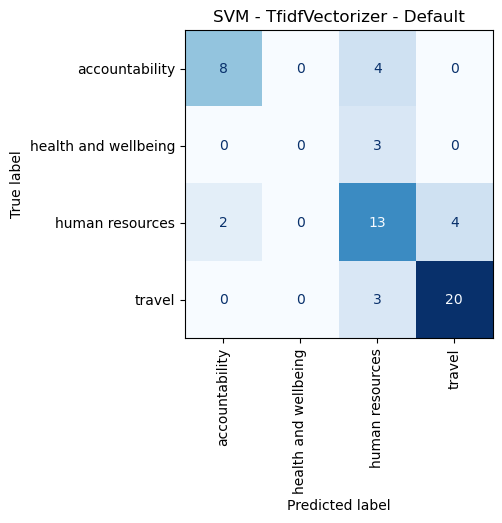

array([0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 2, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2,
       3, 3, 3, 0, 2, 3, 2, 3, 0, 3, 2, 0, 3])

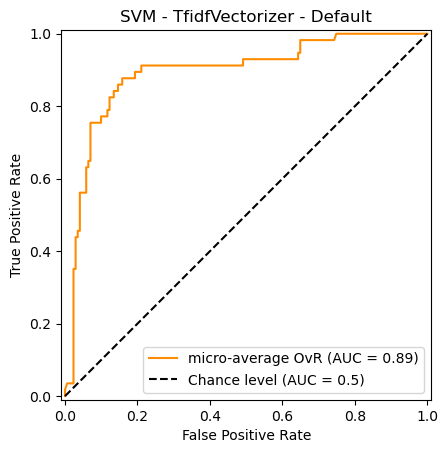

In [130]:
# SVM
train_eval_model(tvect_svm_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'SVM - TfidfVectorizer - Default')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)}


                      precision    recall  f1-score   support

      accountability       0.67      0.67      0.67        12
health and wellbeing       1.00      1.00    

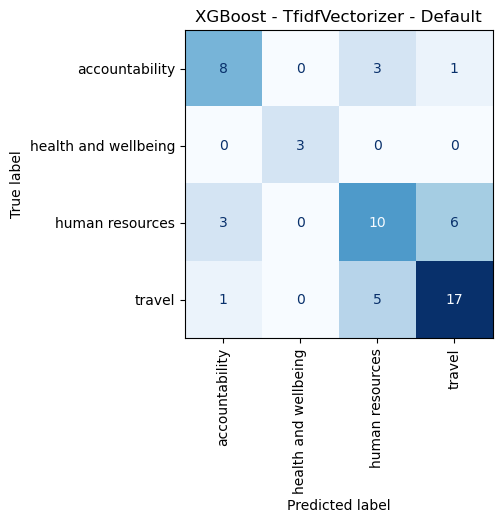

array([0, 3, 2, 2, 0, 0, 0, 3, 2, 3, 0, 1, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       1, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 1, 2, 2, 3, 2,
       3, 2, 0, 0, 3, 3, 3, 3, 0, 3, 2, 0, 3], dtype=int64)

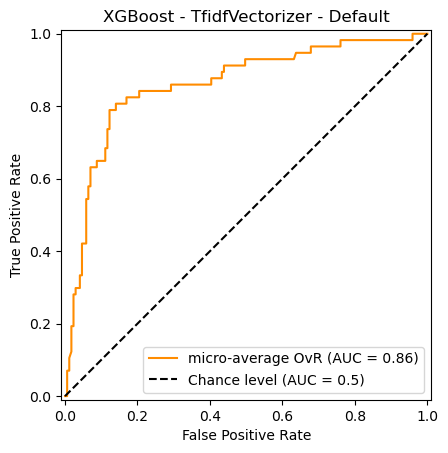

In [131]:
# XGBoost
train_eval_model(tvect_xgb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, 'XGBoost - TfidfVectorizer - Default')

#### Tune hyperparameters

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'log': LogisticRegression(max_iter=10000)}


{'log__C': 10, 'vect__max_df': 1.0, 'vect__max_features': 100, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.79      0.92      0.85        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.67      0.63      0.65        19
              travel       0.76      0.83      0.79        23

            accuracy                           0.74        57
           macro avg       0.55      0.59      0.57        57
        weighted avg       0.69      0.74      0.71        57



Train AUC Sore:  1.00
Test AUC Score:  0.88




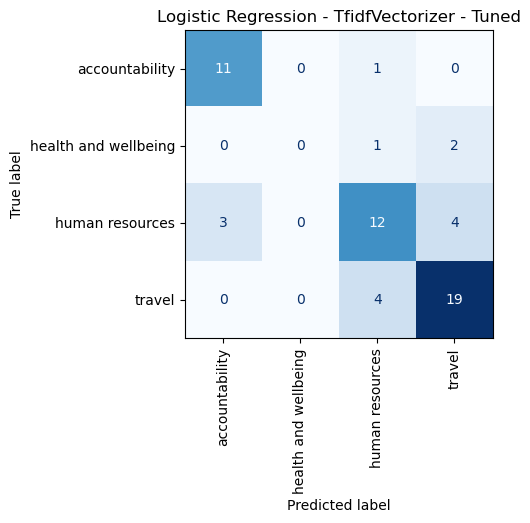

array([0, 2, 2, 0, 0, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 2, 2, 3, 2,
       3, 3, 0, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 0, 3, 0, 3, 2, 0, 3])

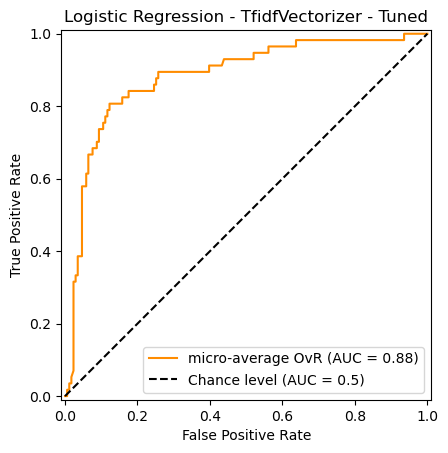

In [132]:
# Logistic Regression
train_tune_model(tvect_log_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, log_param, 'Logistic Regression - TfidfVectorizer - Tuned')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'nb': MultinomialNB()}


{'nb__alpha': 0.1, 'vect__max_df': 0.6, 'vect__max_features': 100, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.82      0.75      0.78        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.67      0.63      0.65        19
              travel       0.68      0.83      0.75        23

            accuracy                           0.70        57
           macro avg       0.54      0.55      0.54        57
        weighted avg       0.67      0.70      0.68        57



Train AUC Sore:  0.97
Test AUC Score:  0.88




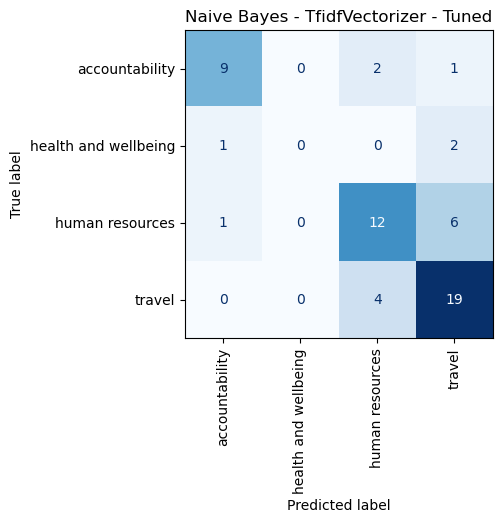

array([0, 2, 3, 0, 2, 2, 0, 3, 2, 3, 0, 0, 2, 0, 3, 0, 3, 2, 2, 2, 3, 2,
       3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 3, 3, 2, 3, 0, 0, 3])

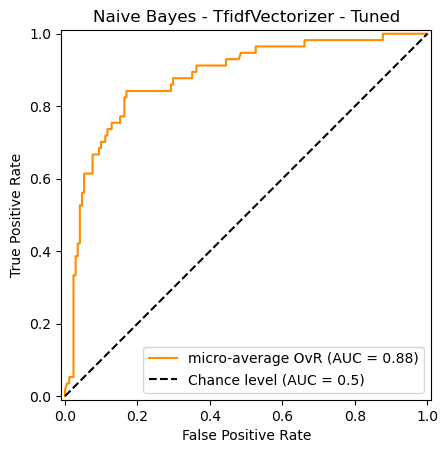

In [133]:
# Naive Bayes
train_tune_model(tvect_nb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, nb_param, 'Naive Bayes - TfidfVectorizer - Tuned')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'svm': SVC(probability=True)}


{'svm__C': 1, 'vect__max_df': 0.6, 'vect__max_features': 100, 'vect__min_df': 0.4}


                      precision    recall  f1-score   support

      accountability       0.88      0.58      0.70        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.57      0.68      0.62        19
              travel       0.73      0.83      0.78        23

            accuracy                           0.68        57
           macro avg       0.54      0.52      0.52        57
        weighted avg       0.67      0.68      0.67        57



Train AUC Sore:  0.99
Test AUC Score:  0.87




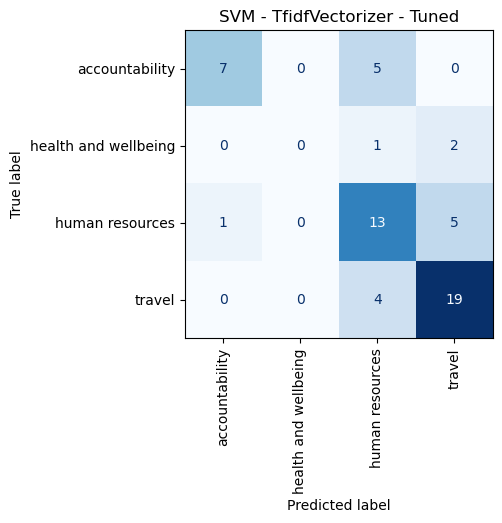

array([0, 2, 3, 0, 2, 2, 2, 3, 2, 3, 0, 2, 2, 0, 3, 2, 3, 3, 2, 2, 3, 2,
       3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 0, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 2, 3, 0, 3, 2, 0, 3])

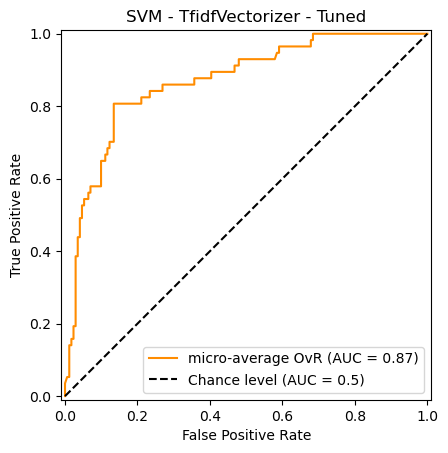

In [134]:
# SVM
train_tune_model(tvect_svm_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, svm_param, 'SVM - TfidfVectorizer - Tuned')

{'vect': TfidfVectorizer(max_features=1000, stop_words='english'), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)}


{'vect__max_df': 0.8, 'vect__max_features': 100, 'vect__min_df': 0.4, 'xgb__max_depth': 10}


                      precision    recall  f1-score   support

      account

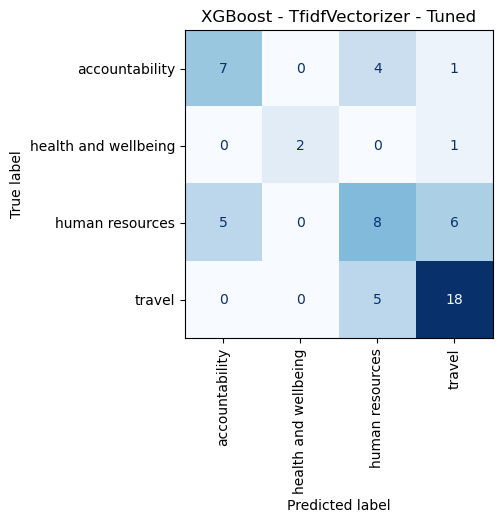

array([0, 2, 2, 2, 0, 0, 0, 3, 0, 3, 0, 1, 2, 0, 3, 2, 3, 3, 3, 2, 3, 2,
       1, 2, 0, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3], dtype=int64)

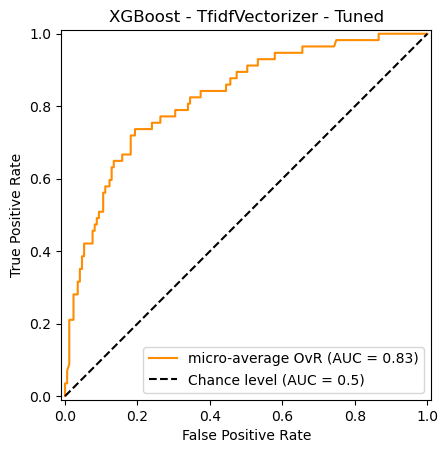

In [135]:
# XGBoost
train_tune_model(tvect_xgb_pipeline, X_train, y_train_encoded, X_test, y_test_encoded, target_names, labels, xgb_param, 'XGBoost - TfidfVectorizer - Tuned')

#### SHAP Analysis on Best Model: Logistic Regression - TfidfVectorizer - Tuned 


In [145]:
# best model from testing is Logistic Regression with TfidfVectorizer
best_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=1000)),
                               ('log', LogisticRegression(max_iter=10000))])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_features=1000, stop_words='english')),
                ('log', LogisticRegression(max_iter=10000))])

In [146]:
feature_names = best_pipeline.named_steps['vect'].get_feature_names_out()

In [147]:
print(feature_names)

['ability' 'abolished' 'abuse' 'academic' 'accept' 'acceptance' 'accepted'
 'access' 'accommodation' 'accompanied' 'accomplishments' 'accordance'
 'account' 'accountability' 'accountable' 'accounting' 'accounts'
 'achieve' 'achieved' 'achievement' 'action' 'actions' 'activities'
 'activity' 'acts' 'actual' 'addition' 'additional' 'address' 'addressed'
 'adjustment' 'administered' 'administration' 'administrative'
 'admissible' 'advance' 'advances' 'advice' 'advisory' 'affairs'
 'affected' 'africa' 'agencies' 'agency' 'agreed' 'agreement' 'agreements'
 'allegations' 'alleged' 'allow' 'allowance' 'amend' 'amended' 'america'
 'amounting' 'analysis' 'annex' 'annual' 'anti' 'applicable' 'applicants'
 'application' 'applications' 'applied' 'applies' 'apply' 'appointed'
 'appointment' 'appointments' 'appraisal' 'approach' 'appropriate'
 'approval' 'approve' 'approved' 'april' 'area' 'areas' 'arise'
 'arrangements' 'arrival' 'article' 'aspects' 'assembly' 'assessed'
 'assessment' 'assessments'

In [148]:
explainer = shap.KernelExplainer(best_pipeline.named_steps['log'].predict_proba, shap.sample(best_pipeline.named_steps['vect'].fit_transform(X_train), 10), feature_names=feature_names)

In [149]:
shap_values = explainer(shap.sample(best_pipeline.named_steps['vect'].fit_transform(X_train), 10))

100%|██████████| 10/10 [01:01<00:00,  6.12s/it]


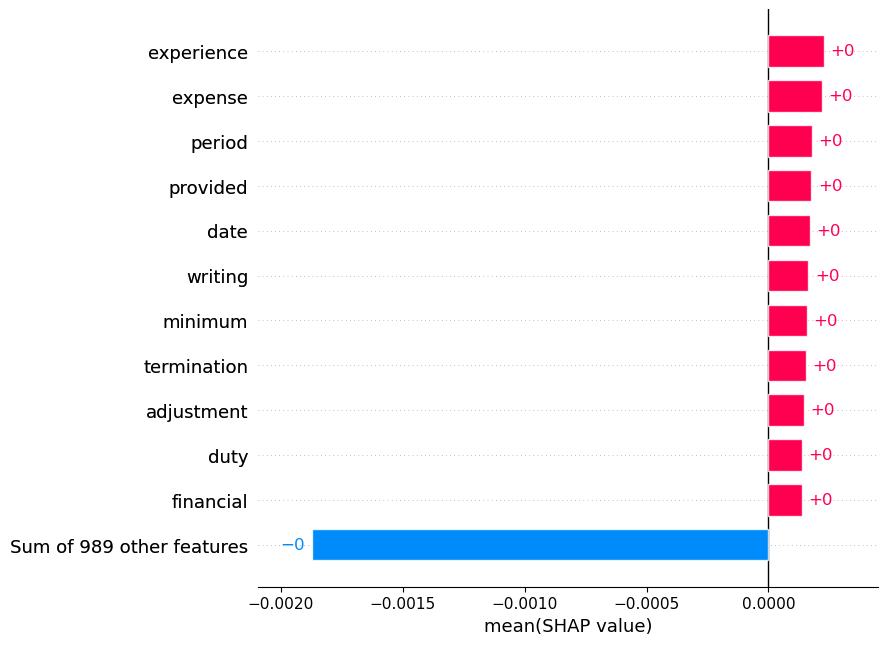

In [150]:
# top words impacting accountability
shap.plots.bar(shap_values[:, :, 0].mean(0), order=shap.Explanation.argsort.flip, max_display=12)

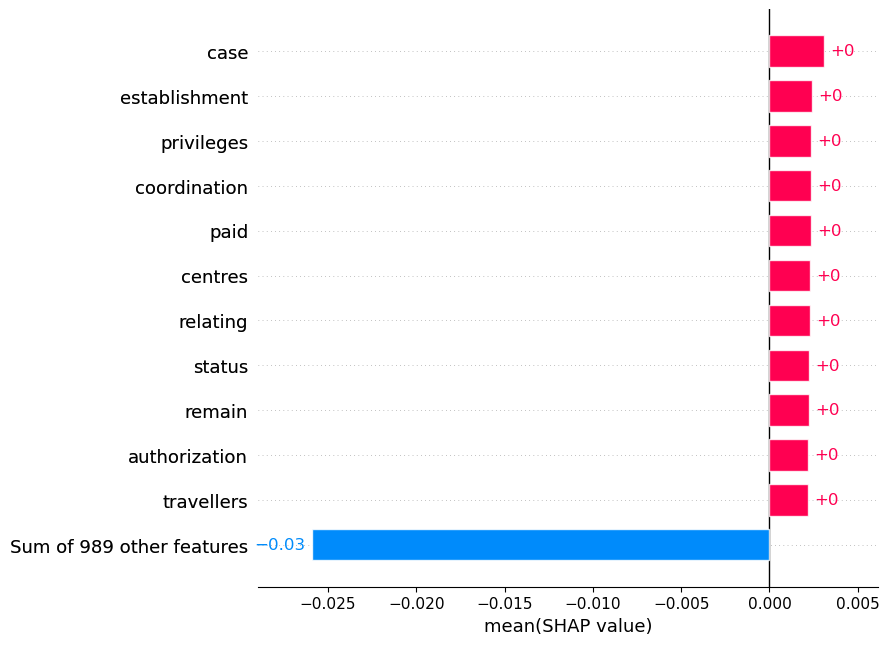

In [151]:
# top words impacting health and wellbeing
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort.flip, max_display=12)

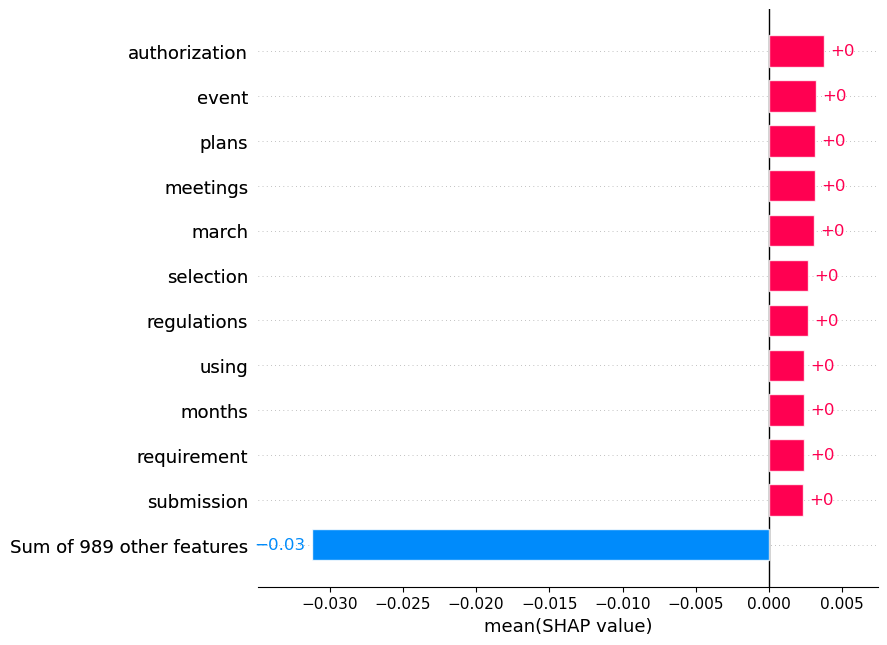

In [152]:
# human resources
shap.plots.bar(shap_values[:, :, 2].mean(0), order=shap.Explanation.argsort.flip, max_display=12)

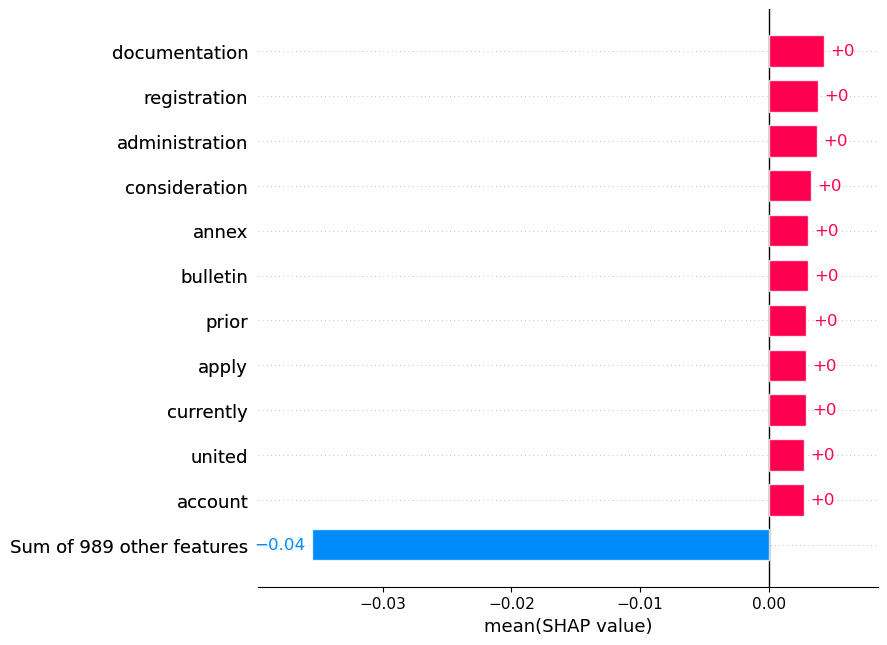

In [153]:
# top words impacting travel
shap.plots.bar(shap_values[:, :, 3].mean(0), order=shap.Explanation.argsort.flip, max_display=12)